This notebook contains code used for generating musical notes with RNN using Tensorflow.

Reference: https://github.com/tensorflow/docs/blob/master/site/en/tutorials/audio/music_generation.ipynb

**Creating a directory 'lofi' to store audio files for training**

In [1]:
!mkdir lofi

In [2]:
import os
from pathlib import Path

os.chdir("/content/lofi")
datadir = Path("/content/lofi")

The train MIDI files are then uploaded into this directory.

In [4]:
from glob import glob

audio_files = glob('*.mid')
audio_files.sort()
print(audio_files)
print('Number of files:', len(audio_files))

['april_showers.mid', 'blue_skies.mid', 'come_again.mid', 'keeping_cool.mid', 'kids.mid', 'laundry_on_the_wire.mid', 'poor_but_happy.mid', 'sense_of_purpose.mid', 'so_broke.mid', 'spring_at_last.mid', 'waves.mid', 'windows_down.mid']
Number of files: 12


In [5]:
sample_file = audio_files[0]
print(sample_file)

april_showers.mid


**Installing pretty_midi library** makes handling MIDI data easy in Python. This library offers functions analyzing, parsing and modifying MIDI files.

In [6]:
!pip install pretty_midi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.6 MB 11.8 MB/s 
     |████████████████████████████████| 51 kB 5.4 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591954 sha256=c6e577b1eb959e329808b9b97082fab755878cd084ab78b094de468b7266da8a
  Stored in directory: /root/.cache/pip/wheels/2a/5a/e3/30eeb9a99350f3f7e21258fcb132743eef1a4f49b3505e76b6
Successfully built pretty-midi


**Loading the sample MIDI file as a PrettyMIDI object** 

In [7]:
import pretty_midi

pm = pretty_midi.PrettyMIDI(sample_file)

In [8]:
_SAMPLING_RATE = 16000

def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

**Inspecting the sample MIDI file to find what instruments are used**

In [9]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


**Extracting musical notes**

In [10]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.3f}')

0: pitch=52, note_name=E3, duration=0.011
1: pitch=49, note_name=C#3, duration=0.011
2: pitch=72, note_name=C5, duration=0.022
3: pitch=46, note_name=A#2, duration=0.011
4: pitch=62, note_name=D4, duration=0.022
5: pitch=65, note_name=F4, duration=0.033
6: pitch=76, note_name=E5, duration=0.033
7: pitch=43, note_name=G2, duration=0.011
8: pitch=40, note_name=E2, duration=0.011
9: pitch=61, note_name=C#4, duration=0.022


__A note can be represented using 3 variables for training the model:__

*   __*pitch*__ - perceptual quality of the sound as a MIDI note number
*   __*step*__ - time elapsed from the previous note or start of the track &
*   __*duration*__ - the difference between the note end and note start times

__The following function represents musical notes as pitch, step & duration__

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections # provides additional data structures for collections of data

def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [12]:
raw_notes = midi_to_notes(sample_file)
raw_notes.sample(10)

,pitch,start,end,step,duration
3386,39,64.413043,64.423913,0.010870,0.010870
1244,96,24.923913,24.967391,0.000000,0.043478
2100,54,40.423913,40.543478,0.054348,0.119565
3354,58,63.804348,63.826087,0.000000,0.021739
726,54,14.815217,14.880435,0.119565,0.065217
1489,72,29.489130,29.782609,0.010870,0.293478
2743,61,51.521739,51.543478,0.000000,0.021739
1961,95,37.793478,37.815217,0.000000,0.021739
1060,39,21.380435,21.391304,0.010870,0.010870
2789,90,52.304348,52.326087,0.000000,0.021739


It may be easier to interpret the note names rather than the pitches.

The function below is used to convert from the numeric pitch values to note names. 

In [13]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['E3', 'C5', 'F4', 'E5', 'C#3', 'D4', 'A#2', 'G2', 'C#4', 'E2'],
      dtype='<U3')

**Plotting pitches of notes for the entire track**





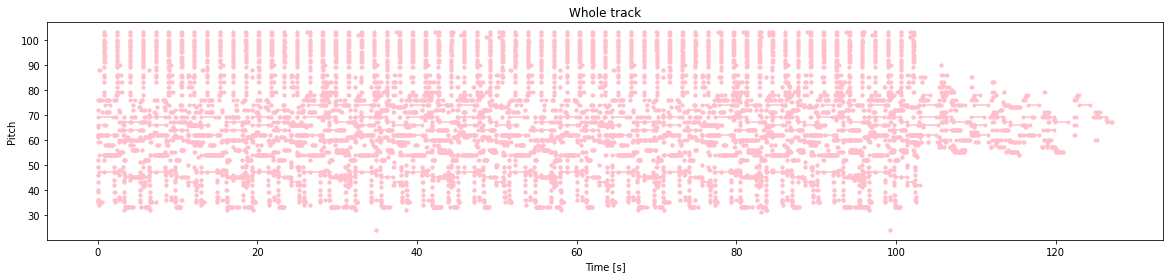

In [17]:
from typing import Dict, List, Optional, Sequence, Tuple

def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="pink", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)
plot_piano_roll(raw_notes)

**Creating train dataset**

In [18]:
num_files = 12
all_notes = []
for f in audio_files[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 86228


In [19]:
import tensorflow as tf

key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

The model is trained on batches of sequences of notes. 

Each example will consist of a sequence of notes as the input features, and the next note as the label. In this way, the model will be trained to predict the next note in a sequence. 

The following function with size seq_length is used to create the features and labels in this format.

In [20]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """returns TF Dataset of sequence and label examples"""
  seq_length = seq_length+1

  # take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)
  
  # normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [21]:
seq_length = 100
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(100, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [22]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (100, 3)
sequence elements (first 10): tf.Tensor(
[[0.40625    0.         0.01086957]
 [0.5625     0.         0.02173913]
 [0.5078125  0.         0.0326087 ]
 [0.59375    0.         0.0326087 ]
 [0.3828125  0.01086957 0.01086957]
 [0.484375   0.         0.02173913]
 [0.359375   0.01086957 0.01086957]
 [0.3359375  0.01086957 0.01086957]
 [0.4765625  0.         0.02173913]
 [0.3125     0.01086957 0.01086957]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=62.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.010869565217391575>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.17391304347826075>}


In [23]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))
train_ds.element_spec

(TensorSpec(shape=(64, 100, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

**Building the RNN model**


The model will have three outputs, one for each note variable. 

For step and duration, a custom loss function is used based on mean squared error that encourages the model to output non-negative values.

In [24]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [25]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 3)]     0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 128)          67584       ['input_1[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            129         ['lstm[0][0]']                   
                                                                                                  
 pitch (Dense)                  (None, 128)          16512       ['lstm[0][0]']                   
                                                                                              

In [26]:
losses = model.evaluate(train_ds, return_dict=True)
losses

1345/1345 [==============================] - 107s 67ms/step - loss: 5.0559 - duration_loss: 0.0672 - pitch_loss: 4.8566 - step_loss: 0.1322


{'loss': 5.055942535400391,
 'duration_loss': 0.06720418483018875,
 'pitch_loss': 4.85657262802124,
 'step_loss': 0.1321607381105423}

In [27]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration': 1.0,
    },
    optimizer=optimizer,
)

In [28]:
model.evaluate(train_ds, return_dict=True)

1345/1345 [==============================] - 89s 65ms/step - loss: 0.4422 - duration_loss: 0.0672 - pitch_loss: 4.8566 - step_loss: 0.1322


{'loss': 0.44219353795051575,
 'duration_loss': 0.06720418483018875,
 'pitch_loss': 4.85657262802124,
 'step_loss': 0.1321607381105423}

**Training the model**

In [29]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

epochs = 1000 # extending the duration of music generated by increasing the number of epochs

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/1000
1345/1345 [==============================] - 210s 154ms/step - loss: 0.2690 - duration_loss: 0.0555 - pitch_loss: 4.1854 - step_loss: 0.0042
Epoch 2/1000
1345/1345 [==============================] - 210s 156ms/step - loss: 0.2561 - duration_loss: 0.0541 - pitch_loss: 3.9684 - step_loss: 0.0036
Epoch 3/1000
1345/1345 [==============================] - 211s 157ms/step - loss: 0.2514 - duration_loss: 0.0534 - pitch_loss: 3.8883 - step_loss: 0.0035
Epoch 4/1000
1345/1345 [==============================] - 209s 156ms/step - loss: 0.2484 - duration_loss: 0.0526 - pitch_loss: 3.8433 - step_loss: 0.0036
Epoch 5/1000
1345/1345 [==============================] - 211s 157ms/step - loss: 0.2420 - duration_loss: 0.0510 - pitch_loss: 3.7465 - step_loss: 0.0037
Epoch 6/1000
1345/1345 [==============================] - 211s 157ms/step - loss: 0.2359 - duration_loss: 0.0496 - pitch_loss: 3.6501 - step_loss: 0.0038
Epoch 7/1000
1345/1345 [==============================] - 216s 160ms/step - 

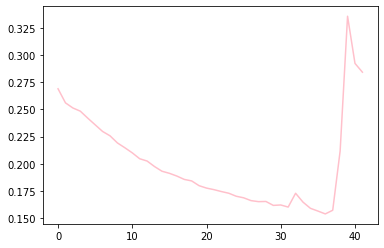

In [30]:
plt.plot(history.epoch, history.history['loss'], label='total loss', color='pink')
plt.show()

**Deploying the model to generate musical notes**

In [31]:
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:
  """Generates a note IDs using a trained sequence model."""

  # add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']
 
  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [32]:
temperature = 2.0 # hyperparameter of neural networks used to control the randomness of predictions by scaling the logits before applying softmax.
# the higher the value of temperature, the more diverse the RNN predictions 
num_predictions = 1000

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# the initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step + 0.5
  end = start + duration
  input_note = (pitch, step+0.5, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))
generated_notes.head(10)

1/1 [==============================] - 0s 27ms/step


,pitch,step,duration,start,end
0,40,0.533945,0.084561,0.533945,0.618506
1,76,0.561251,1.577323,1.095196,2.672520
2,87,0.556752,1.934647,1.651949,3.586595
3,91,0.560148,1.988085,2.212097,4.200181
4,87,0.561404,1.993510,2.773501,4.767011
5,89,0.564310,1.993374,3.337811,5.331185
6,46,0.564768,1.993666,3.902578,5.896244
7,87,0.560180,1.958686,4.462758,6.421444
8,89,0.567253,1.994131,5.030011,7.024142
9,87,0.566612,1.995305,5.596623,7.591929


**Creating a MIDI file**

In [ ]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 80,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [35]:
out_file = 'i_let_my_worlds_collide.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)

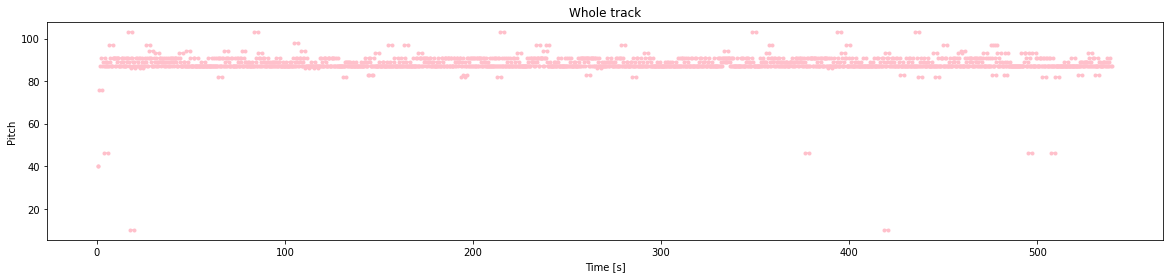

In [36]:
plot_piano_roll(generated_notes)